# Linguistic development

In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from nltk import word_tokenize
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage, ward, fcluster
from stop_words import get_stop_words
import seaborn as sns


from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC, SVC

from yellowbrick.text import UMAPVisualizer
from yellowbrick.style import set_palette

import umap
from utils import add_epoch_division, alter_epoch_division, linkage_matrix, plot_dendrogram, remove_noise_poet, text_cleaning

/Users/jan/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
LOWERCASE = True
MAX_FEATURES = 10000
NOISELESS = True
if NOISELESS:
    PATH = "../corpora/amann_poems_noiseless.csv"
else:
    PATH = "../corpora/amann_poems.csv"
DIM_RED = False
STOP_WORDS = get_stop_words("de")

### corpus loading & vectorizing

In [3]:
corpus = text_cleaning(pd.read_csv(PATH))

In [4]:
shorten_epochs = ["Frühbarock", "Hochbarock", "Aufklärung", "Klassik"]
corpus = corpus[corpus.epoch.isin(shorten_epochs)]

In [5]:
text = corpus["poem"].values
labels = LabelEncoder().fit_transform(corpus["epoch"].values)
unique_epochs = list(np.unique(corpus["epoch"]))


vectorizer = TfidfVectorizer(max_df=0.5,
                             lowercase=LOWERCASE,
                             max_features=MAX_FEATURES,
                             stop_words=STOP_WORDS)
vector = vectorizer.fit_transform(text)

In [6]:
"""TODO: weg
for epoch in list(corpus.epoch.unique()):
    df = corpus[corpus.epoch == epoch]
    Path(f"../corpora/malletfiles/epochtexts/{epoch}").mkdir(parents=True, exist_ok=True)
    for idx, row in df.iterrows():
        name = row.poet + "_" + row.epoch
        with open(f"../corpora/malletfiles/epochtexts/{epoch}/{name}.txt", "w+") as f:
            f.write(row.poem)
"""

'TODO: weg\nfor epoch in list(corpus.epoch.unique()):\n    df = corpus[corpus.epoch == epoch]\n    Path(f"../corpora/malletfiles/epochtexts/{epoch}").mkdir(parents=True, exist_ok=True)\n    for idx, row in df.iterrows():\n        name = row.poet + "_" + row.epoch\n        with open(f"../corpora/malletfiles/epochtexts/{epoch}/{name}.txt", "w+") as f:\n            f.write(row.poem)\n'

### UMAP

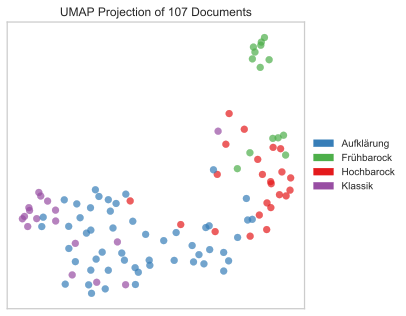

In [7]:
set_palette('set1')
umapv = UMAPVisualizer(size=(480, 380))
umapv.fit(vector, list(corpus.epoch))
umapv.show()

In [8]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(vector)

In [10]:
%%time
def classify_svm(vectorized_text, classes, cv=3):   
    
    pipeline = Pipeline([("umap", umap.UMAP()), ("svc", SVC())])
    params_grid_pipeline = {
        "umap__n_neighbors": [5, 20],
        "umap__n_components": [2],
        "svc__C": [1.0, 2.0, 3.0],
        "svc__max_iter": [1000],
    }
    """
    params_grid_pipeline = {
        "umap__n_neighbors": [5],
        "umap__n_components": [2],
        "svc__C": [1.0],
        "svc__max_iter": [1000],
    }
    """

    clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline, cv=cv)
    
    clf_pipeline.fit(vectorized_text, classes)
    
    # SVM
    svm_classifier = clf_pipeline.best_estimator_
    best_params = clf_pipeline.best_params_

    # cross validation des Trainingsdatensatzes
    svm_scores = cross_val_score(svm_classifier, vectorized_text, classes, cv=cv)
    preds = cross_val_predict(svm_classifier, vectorized_text, classes, cv=cv)
    
    svm_mean = np.mean(svm_scores)

    print("Der Mittelwert der cross validation bei der Klassifizierung " 
          + f" mit SVM ist {str(np.around(svm_mean, decimals=3))}."
          + "\n")
    
    return preds, best_params
preds, best_params = classify_svm(vector, labels)

Der Mittelwert der cross validation bei der Klassifizierung  mit SVM ist 0.719.

CPU times: user 1min 58s, sys: 1.89 s, total: 2min
Wall time: 1min 55s


In [96]:
#TODO: weg?
svm = SVC()
X_train = vector[:86]
y_train = labels[:86]
X_test = vector[86:]
y_test = labels[86:]

svm.fit(X_train, y_train)

print(svm.support_)

[ 3  5  8 10 11 13 14 16 18 19 20 21 23 26 27 28 32 35 36 38 39 40 41 42
 43 45 46 48 49 50 53 56 58 59 63 64 66 67 69 70 72 74 75 76  9 17 22 29
 34 37 60 68 71  0  2  6  7 24 47 52 54 55 61 65 73  1  4 12 15 30 31 44
 51 57 62]


In [62]:
ppoets = []
good_preds = []
#corpus = corpus.reset_index()
for idx, (p, l) in enumerate(zip(preds, labels)):
    if p != l:
        ppoets.append((corpus.at[idx, "poet"], corpus.at[idx, "year"]))
    else:
        good_preds.append((corpus.at[idx, "poet"], corpus.at[idx, "year"]))

In [75]:
corpus.head(1)

,id,poet,poem,year,epoch,poemlength
0,0,"Abschatz, Hans Aßmann von",Du angenehmer Häyn voll stiller Einsamkeiten/ ...,1679,Hochbarock,62284


In [76]:
good_poets = [t[0] for t in good_preds]
good_years = [t[1] for t in good_preds]
shorten_corpus = corpus[(corpus.poet.isin(good_poets)) & (corpus.year.isin(good_years))]

In [85]:
text2 = shorten_corpus["poem"].values
labels2 = LabelEncoder().fit_transform(shorten_corpus["epoch"].values)
unique_epochs2 = list(np.unique(shorten_corpus["epoch"]))


vectorizer = TfidfVectorizer(max_df=0.5,
                             lowercase=LOWERCASE,
                             max_features=MAX_FEATURES,
                             stop_words=STOP_WORDS)
vector2 = vectorizer.fit_transform(text2)

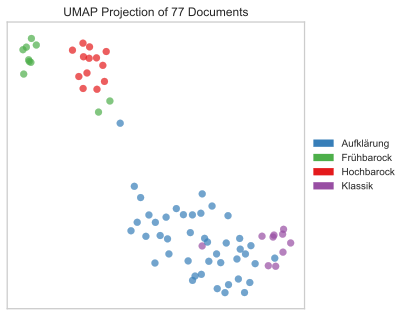

In [87]:
set_palette('set1')
umapv2 = UMAPVisualizer(size=(480, 380))
umapv2.fit(vector2, list(shorten_corpus.epoch))
umapv2.show()